## Challenge: A deep dive into Dialogue Act Recognition
### **Full Dataset Version**
**By**: *Ward Van den Bossche*, **Student ID**: *0605083*

### As of 01/03/2025 the full dataset performed equally (even worse?) as the subset
Here are some chatGPT suggestions to the question "I'm training an utterance level RNN and LSTM on dstc8 schema guided dialogue dataset for dialogue act recognition, and I used a small subset of the data at first, then I used the full dataset, and my performance was about equally worse, what could the problem be here?":

If your utterance-level RNN/LSTM model performs poorly on both a small subset and the full DSTC8 Schema-Guided Dialogue dataset, the issue is likely not the dataset size. Here are some potential reasons:

1. Model Capacity and Architecture Issues
Underfitting: If your model is too simple (e.g., too few layers or hidden units), it might not be able to capture the complexity of dialogue act patterns.
Overfitting: If your model is too large relative to the amount of training data, it might memorize noise rather than learning useful features.
Lack of Context: Since dialogue acts depend on conversational history, an utterance-level model may struggle without sufficient contextual information.
2. Data Representation and Preprocessing Issues
Feature Engineering Issues: If you're using raw text embeddings, are they sufficiently expressive? Try pre-trained embeddings (e.g., GloVe, BERT embeddings) instead of random initialization.
Tokenization Issues: Poor tokenization or out-of-vocabulary issues can lead to ineffective embeddings.
Class Imbalance: Some dialogue acts may be rare in the dataset, leading to poor generalization for those classes. Try class rebalancing techniques (e.g., weighted loss, oversampling, data augmentation).
3. Optimization and Training Issues
Learning Rate Issues: If the learning rate is too high, training might be unstable; if too low, it might converge to a poor local minimum.
Gradient Vanishing/Exploding: RNNs suffer from this problem. Are you using gradient clipping or batch normalization?
Batch Size: A very small or very large batch size might lead to poor generalization.
4. Evaluation and Labeling Issues
Label Ambiguity: Some dialogue acts might overlap or be mislabeled, making it harder for the model to learn.
Incorrect Metric Interpretation: Are you measuring accuracy, F1-score, or another metric? Some dialogue act classes may require weighted evaluation.
5. Lack of Multimodal/Contextual Information
Utterance-Level Limitation: Dialogue acts often depend on previous context. If your model only processes single utterances, try including past utterances (e.g., hierarchical RNN, transformers, or using speaker information).
Ignoring Speaker Information: The role of the speaker (user vs. system) can affect dialogue acts.
Would you like help debugging any specific aspect, such as loss curves, model structure, or data representation?

In [23]:
USING_COLAB = False
if USING_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

"The Schema-Guided Dialogue (SGD) dataset consists of over 20k annotated multi-domain, task-oriented conversations between a human and a virtual assistant" (https://github.com/google-research-datasets/dstc8-schema-guided-dialogue) It pertains to different domains like banking and weather. In addition to a training and test set, there is also a crowdfunded variant dataset (SGD-X) that can be used to test a model's generalization capabilities to real-world settings.  What's interesting for this project is the dialogue act annotations, which are defined for both system and user. Some possible values include: INFORM, REQUEST, CONFIRM. A complete list can be found on the dataset's github README.md file.

In [24]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import torch
import pandas as pd
import json
import pickle
import torch.utils.data
from tqdm import tqdm
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
import re

# Set random seed for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Only need to run this code block once, to get a properly formatted json file for test and train set

# train_path = os.path.join(os.getcwd(), 'SGD Dataset', 'TrainSet.json')
# test_path = os.path.join(os.getcwd(), 'SGD Dataset', 'TestSet.json')

# def format_json(path):
#     # For readability purposes, ensure proper structure in the train/test set files
#     with open(path, "r") as f:
#         data = json.load(f)

#     with open(path.replace(".json", "_formatted.json"), "w") as f:
#         json.dump(data, f, indent=4, ensure_ascii=False)

# format_json(train_path)
# format_json(test_path)

In [26]:
if USING_COLAB:
  path_to_dataset = os.path.join(os.getcwd(), "drive", "MyDrive", "Current Trends VUB", 'SGD Dataset')
else:
  path_to_dataset = os.path.join(os.getcwd(), 'SGD Dataset')
path_to_train = os.path.join(path_to_dataset, "TrainSet_Full.json")
path_to_test = os.path.join(path_to_dataset, "TestSet_Full.json")

### Implementation 1: Simple RNN

For the first implementation we'll train a simple RNN and LSTM on the utterances of this dataset, note that this is an utterance level model, trained on a (small) subset of the whole dataset. (TODO: might be interesting to compare with the whole dataset). At inference time the user can then input an utterance and have the system return a dialogue act predicted by the neural network. The code is based on WPOs from the course "Deep Learning" of the master applied computer science at VUB, where it was used in a toy dataset for sentiment analysis and could serve as a benchmark to compare our future models with.

#### Preprocessing
The preprocessing step involves extracting all utterances from the.json files, together with their dialogue acts, which will be used as "labels" in our prediction task. In addition to this, the speaker can be USER or SYSTEM, this information will be encoded in a separate token.

In [27]:
EOD = "<eod>" # End of dialogue token

In [28]:
def extract_turn_data(file_path):
    all_data = []
    with open(file_path, 'r') as f:
        data = json.load(f)
        for dialogue in data:
            for turn in dialogue['turns']:
                all_data.append({
                    'speaker': turn['speaker'],
                    'utterance': turn['utterance'],
                    'act': turn["dialogue_act"]
                })
            all_data[-1]['utterance'] += f" {EOD}" # Add an End Of Dialogue marker at the end of last utterance in turn
    return all_data

extracted_train = extract_turn_data(path_to_train)
extracted_test = extract_turn_data(path_to_test)

for i in range(22, 25):
    print(extracted_train[i])

{'speaker': 'USER', 'utterance': 'I appreciate it very much. That would be all.', 'act': 'USER_THANK_YOU|USER_GOODBYE'}
{'speaker': 'SYSTEM', 'utterance': 'Have a good time! <eod>', 'act': 'SYSTEM_GOODBYE'}
{'speaker': 'USER', 'utterance': 'Hi i need a help, i am very hungry, I am looking for a restaurant', 'act': 'USER_INFORM_INTENT'}


In [29]:
acts = list(set([data['act'] for data in extracted_train] + [data['act'] for data in extracted_test]))

acts_labels = {act : i for i, act in enumerate(acts)}
inv_acts_labels = {v: k for k, v in acts_labels.items()}

# Modified code for processing turns
label_train = [ acts_labels[turn['act']] for turn in extracted_train ]
label_test = [ acts_labels[turn['act']] for turn in extracted_test ]

In [30]:
print(acts_labels, label_train[:5])

{'USER_SELECT': 0, 'USER_NEGATE_INTENT|USER_GOODBYE': 1, 'SYSTEM_GOODBYE': 2, 'USER_SELECT|USER_INFORM|USER_INFORM_INTENT': 3, 'SYSTEM_NOTIFY_FAILURE|SYSTEM_REQ_MORE': 4, 'USER_INFORM|USER_REQUEST_ALTS': 5, 'USER_NEGATE_INTENT|USER_INFORM|USER_INFORM_INTENT': 6, 'SYSTEM_OFFER_INTENT': 7, 'SYSTEM_OFFER|SYSTEM_INFORM_COUNT': 8, 'USER_REQUEST': 9, 'USER_INFORM|USER_INFORM_INTENT': 10, 'USER_INFORM_INTENT|USER_NEGATE_INTENT': 11, 'SYSTEM_INFORM|SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 12, 'USER_INFORM_INTENT': 13, 'USER_THANK_YOU|USER_INFORM_INTENT': 14, 'USER_INFORM|USER_AFFIRM': 15, 'USER_NEGATE|USER_THANK_YOU': 16, 'USER_INFORM': 17, 'USER_REQUEST_ALTS': 18, 'USER_INFORM_INTENT|USER_SELECT': 19, 'USER_SELECT|USER_INFORM_INTENT': 20, 'SYSTEM_REQUEST': 21, 'USER_NEGATE': 22, 'USER_INFORM_INTENT|USER_THANK_YOU': 23, 'SYSTEM_NOTIFY_SUCCESS': 24, 'USER_SELECT|USER_GOODBYE': 25, 'SYSTEM_OFFER|SYSTEM_NOTIFY_FAILURE': 26, 'SYSTEM_INFORM|SYSTEM_NOTIFY_SUCCESS': 27, 'USER_AFFIRM_INTENT|USER_INFORM': 

In [31]:
def clean_utterances(extracted_turns):
    utterances = []
    
    for data in extracted_turns:
        utterance = data['utterance'].lower()

        # Replace monetary values: "$23.53", "$1,000", "$500"
        utterance = re.sub(r'\$\d+(?:,\d{3})*(?:\.\d{2})?', '<price>', utterance)

        # Replace all remaining numbers with <number>
        utterance = re.sub(r'\b\d+\b', '<number>', utterance)

        # Separate "?" from words (turns "hello?" into "hello ?")
        # such that it can become it's own token and maybe help the model recognize "requests"
        utterance = re.sub(r'(\w+)\?', r'\1 ?', utterance)

        # Remove unwanted characters
        chars_to_erase = ['.', ',', '!', '$']
        for char in chars_to_erase:
            utterance = utterance.replace(char, '')

        utterances.append(utterance)
    
    return utterances


In [32]:
utterances_train = clean_utterances(extracted_train)
utterances_test = clean_utterances(extracted_test)

In [33]:
word_freq = Counter()
for utterance in utterances_train:
    utterance_words = utterance.split()
    word_freq.update(utterance_words)

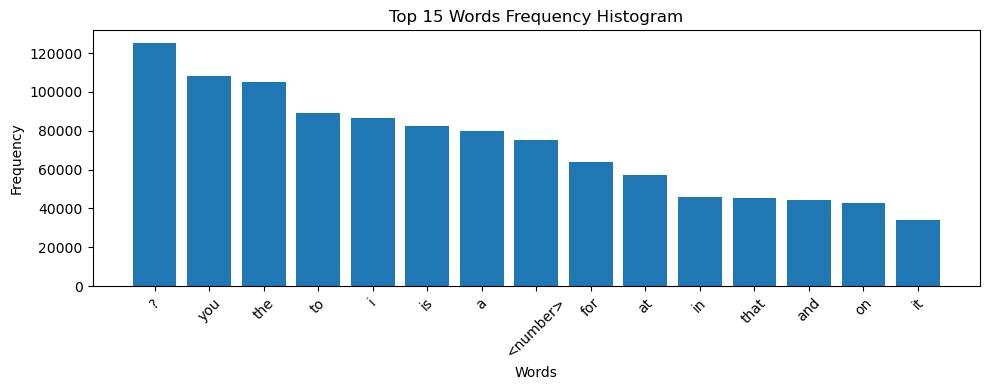

In [34]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [35]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print(f"Total words are: {len(word_map)}")

Total words are: 5173


In [36]:
def encode_text(data, max_len):
    """
    Assign a numerical value (0 to len(word_map)) to each word in the
    utterance while handling special tokens.
    """
    encoded_texts = []
    
    for utterance in data:
        utterance_words = utterance.lower().split()
        is_last_utterance = utterance_words[-1] == EOD.lower()
        adjusted_max_len = max_len - (3 if is_last_utterance else 2)  # Adjust for special tokens
        words = utterance_words[:adjusted_max_len]

        # Tokenization with special tokens
        tokenized = [word_map['<start>']]
        tokenized += [word_map.get(word, word_map['<unk>']) for word in words]
        tokenized.append(word_map['<end>'])
        
        if is_last_utterance:
            tokenized.append(word_map[EOD])
        
        # Padding
        tokenized += [word_map['<pad>']] * (adjusted_max_len - len(words))
        
        encoded_texts.append(tokenized)
    
    return encoded_texts


In [37]:
encoded_texts = encode_text(utterances_train, max_len = 100)
encoded_texts_test = encode_text(utterances_test, max_len = 100)

In [38]:
# test one sample
example_tokens = encoded_texts[23]
print(" ".join([rev_word_map[t] for t in example_tokens]))
print(len(example_tokens))

<start> have a good time <eod> <end> <eod> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
100


#### Dataset and Data Loaders

In [39]:
X_train = torch.tensor(encoded_texts)    # (number_of_samples, max_length)
y_train = torch.LongTensor(label_train)  # (number_of_samples)
X_test = torch.tensor(encoded_texts_test)
y_test = torch.LongTensor(label_test)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           num_workers=6,
                                           batch_size=128, 
                                           shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          num_workers=6,
                                          batch_size=128, 
                                          shuffle=True)

#### Architectures

RNN Network defined by:

$h_t= \tanh \left(W_h \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>

In [40]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super(RNN, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        self.W_h = nn.Linear(input_sz + hidden_sz, hidden_sz)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device),
                    torch.zeros(batch_size, self.hidden_size).to(device))

        hidden_states = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            common_input = torch.cat([x_t, h_t], dim=-1)
            h_t = torch.tanh(self.W_h(common_input))
            hidden_states.append(h_t.unsqueeze(1))

        hidden_states = torch.cat(hidden_states, dim=1)

        return hidden_states

In [41]:
class LSTM(nn.Module):
    
    def __init__(self, input_sz, hidden_sz):
        
        super(LSTM, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #c_t: new memory (the new memory)
        self.W_c = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #i_t: input gate (how much to take from the new memory)
        self.W_i = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #f_t: forget gate (how much to forget from the old memory)
        self.W_f = nn.Linear(input_sz + hidden_sz, hidden_sz)

        #o_t: output gate (how much to take from the new memory to represent the output)
        self.W_o = nn.Linear(input_sz + hidden_sz, hidden_sz)

        self.init_weights()
        
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
            
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()  
        
        # initialize h_t and c_t to zeros
        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device), 
                    torch.zeros(batch_size,self.hidden_size).to(device))
        
        hidden_states = []
        
        for t in range(seq_len):
            # get the input at the current timestep 
            x_t = x[:, t, :]
            
            # run the LSTM Cell
            common_input = torch.cat([x_t, h_t], dim = -1)
            
            new_c = torch.tanh(self.W_c(common_input))
            i_t = torch.sigmoid(self.W_i(common_input))
            f_t = torch.sigmoid(self.W_f(common_input))
            c_t = f_t * c_t + i_t * new_c
            
            o_t = torch.sigmoid(self.W_o(common_input))
            h_t = o_t * torch.tanh(c_t)
            
            # save the hidden states in a list
            hidden_states.append(h_t.unsqueeze(1))
            
        hidden_states = torch.cat(hidden_states, dim = 1)
            
        return hidden_states

In [42]:
class Net(nn.Module):
    
    def __init__(self, input_embedding_size, hidden_size, pooling_type = 'last_hidden_state'):
        
        super().__init__()

        self.embedding = nn.Embedding(len(word_map), input_embedding_size)
        # self.rnn = RNN(input_embedding_size, hidden_size) # Uncomment for RNN (and change in forward pass)
        self.lstm = LSTM(input_embedding_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, len(acts_labels))
        self.pooling_type = pooling_type
        
    def forward(self, x):
        
        # x is of shape (batch_size, max_seq_length)
        x = self.embedding(x)   # (batch_size, seq_len, embed_dim)
        x = self.lstm(x)        # (batch_size, seq_len, hidden_size)

        if self.pooling_type == "last_hidden_state":
            x = x[:, -1, :]     # (batch_size, hidden_size)
        else:
            x = x.mean(1)       # (batch_size, hidden_size)

        x = self.classifier(x)         # (batch_size, len(acts_labels))
        return x

#### Training

In [43]:
def train(model, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # move to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # run forward-backward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # keep track of loss and accuracy
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = train_loss / (batch_idx+1)
    epoch_acc = 100.* correct / total
    print('Epoch {}/{}, Iter {}/{}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch, epochs, batch_idx, 
                                                                                       len(train_loader),
                                                                                       epoch_loss, 
                                                                                       epoch_acc))
    return epoch_loss, epoch_acc

In [44]:
model = Net(input_embedding_size = 256, hidden_size = 512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
epochs = 10

losses = []
accuracies = []

for epoch in range(epochs):
    epoch_loss, epoch_acc = train(model, optimizer, criterion, epoch)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

Epoch 0/10, Iter 2577/2578, Train Loss: 3.271, Train Accuracy: 10.293
Epoch 1/10, Iter 2577/2578, Train Loss: 3.267, Train Accuracy: 10.270
Epoch 2/10, Iter 2577/2578, Train Loss: 3.267, Train Accuracy: 10.325
Epoch 3/10, Iter 2577/2578, Train Loss: 3.267, Train Accuracy: 10.293
Epoch 4/10, Iter 2577/2578, Train Loss: 3.266, Train Accuracy: 10.226


KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss Curve')

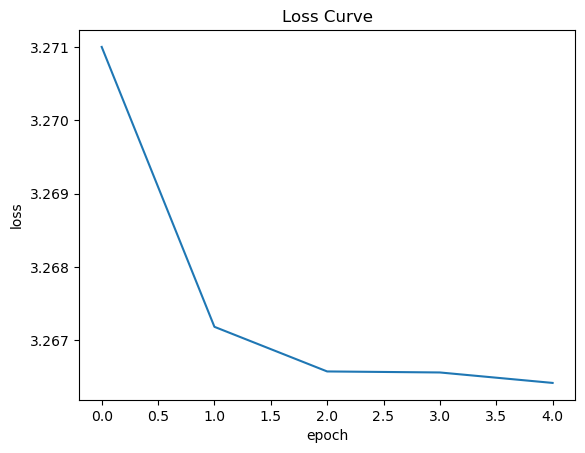

In [45]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Curve')

Text(0.5, 1.0, 'Accuracy Curve')

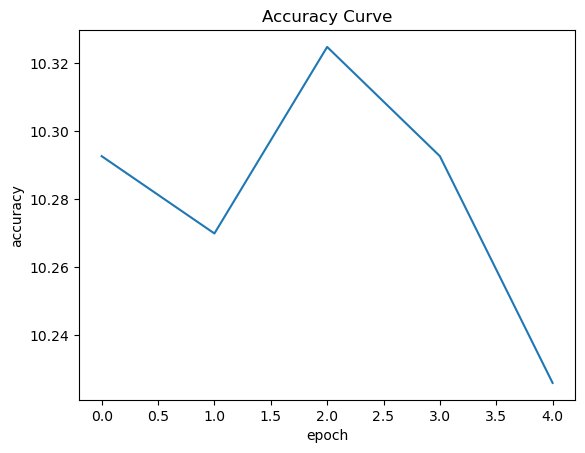

In [46]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')

In [47]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

acc = 100.*correct/total
print('Test Accuracy: {:.3f}'.format(acc))
top5_acc = 0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.topk(5, 1, True, True)
        total += targets.size(0)
        correct += torch.sum(predicted.eq(targets.view(-1, 1)))
top5_acc = 100.*correct/total
print('Top 5 Test Accuracy: {:.3f}'.format(top5_acc))

100%|██████████| 661/661 [00:29<00:00, 22.63it/s]


Test Accuracy: 10.658


100%|██████████| 661/661 [00:28<00:00, 22.92it/s]

Top 5 Test Accuracy: 24.751


In [48]:
sample = inputs[5]
sentence = ' '.join([rev_word_map[w] for w in sample.tolist()])
print(sentence)
print("-------------------")

output = model(sample.unsqueeze(0))
prob, pred = F.softmax(output, dim = -1).max(1)

print('index {} ({}) is predicted with a probability of {}'.format(pred.item(), inv_acts_labels[pred.item()], prob.item()))
print('True label is {}'.format(inv_acts_labels[targets[5].item()]))
print("-------------------")

all_probs = F.softmax(output, dim = -1)

predictions_with_probs = [(inv_acts_labels[i], p.item()) for i, p in enumerate(all_probs[0])]
# for pred, prob in predictions_with_probs:
#     print(f"{pred}: {prob:.3f}")

# Top 5 predictions and top 5 accuracy
top_5_preds = all_probs.topk(5)
top_5_preds_indices = top_5_preds.indices[0]
top_5_preds_probs = top_5_preds.values[0]
top_5_preds_with_probs = [(inv_acts_labels[i.item()], p.item()) for i, p in zip(top_5_preds_indices, top_5_preds_probs)]

print("Top 5 predictions with probabilities:")
for pred, prob in top_5_preds_with_probs:
    print(f"{pred}: {prob:.3f}")

<start> would you like anything else ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
-------------------
index 21 (SYSTEM_REQUEST) is predicted with a probability of 0.10502166301012039
True label is SYSTEM_REQ_MORE
-------------------
Top 5 predictions with probabilities:
SYSTEM_REQUEST: 0.105
USER_INFORM: 0.098
SYSTEM_CONFIRM: 0.071
SYSTEM_OFFER: 0.064
USER_REQUEST: 0.054
